In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob
from PIL import Image

## Mount Drive & Load Images

In [51]:
#mount drive
from google.colab import drive

drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/CS528_Final_Project/data/track_2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/CS528_Final_Project/data/track_2


In [52]:
train_imgs = np.load('train_dataset_initial.npz')['X_data']
train_labels = np.load('train_dataset_initial.npz')['Y_data']

print("Train images shape:", train_imgs.shape)
print("Train Labels shape:", train_labels.shape)

Train images shape: (57613, 60, 80, 3)
Train Labels shape: (57613, 22)


In [53]:
print(train_labels[1])

[-1. -1. -1. -1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0. 35. -1.]


## Dataset Info

In [54]:
def detect_tape(image):
    height, width, _ = image.shape
    # Grab slice of the image
    roi = image[(int(height * .70)):(int(height * .90)), :]

    # Convert to HSV
    hsv = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)

    # Tuned
    low = np.array([95, 95, 95])
    high = np.array([120, 240, 240])

    mask = cv2.inRange(hsv, low, high)
    moments = cv2.moments(mask)

    # Less than 25 pixels of blue = no tape detected
    if moments["m00"] < 150:
        return None

    blue_centroid = moments["m10"] / moments["m00"]

    return blue_centroid

In [55]:
bad_image_indices = []

for i in range(train_imgs.shape[0]):
  image_arr = train_imgs[i]
  # Unstandardize image
  image_arr = (image_arr * 255).astype(np.uint8)

  blue_centroid = detect_tape(image_arr)

  # If line detected
  if blue_centroid:
    # Threshold for anomaly
    if ((blue_centroid <= 15 and train_labels[i][-1] == 1.0) or (blue_centroid >= 72 and train_labels[i][-1] == -1.0)):
      bad_image_indices.append(i)

print(len(bad_image_indices))

68


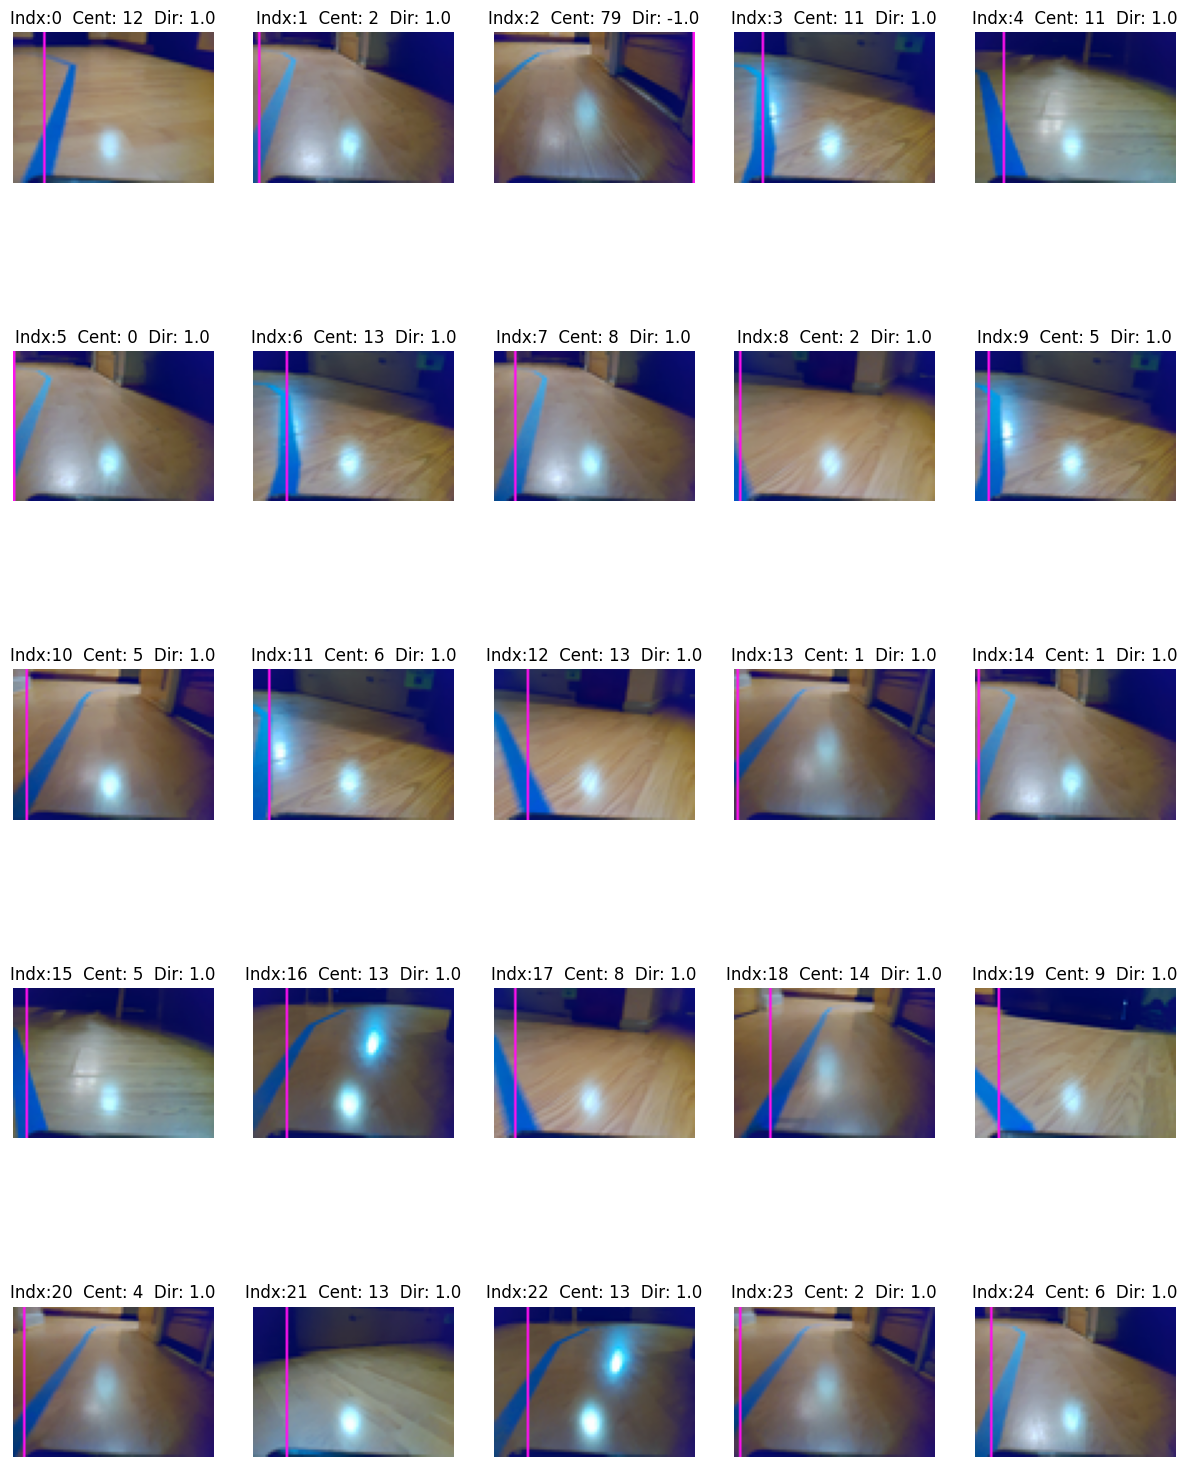

In [56]:
plt.figure(figsize=(15, 20))

for i in range(25):
  ax = plt.subplot(5, 5, i + 1)

  image_arr = train_imgs[bad_image_indices][i]
  # Unstandardize image
  image_arr = (image_arr * 255).astype(np.uint8)

  blue_centroid = detect_tape(image_arr)
  # If tape exists in the image
  if blue_centroid is not None:
    image_arr[:, int(blue_centroid), :] = [255, 16, 240]

    title = "Indx:" + str(i) + "  Cent: " + str(int(blue_centroid)) + "  Dir: " + str(train_labels[bad_image_indices][i][-1])
  else:
    title = 'None'

  plt.imshow(image_arr)
  plt.title(title)
  plt.axis("off")

plt.show()

In [57]:
# Loop through those 68 images and see which indices are actually okay.

human_parsed_ok_indices = set[(2, 21, 27, 38, 46, 39, 47, 58)]

indices_to_remove = []

for i in range(len(bad_image_indices)):
  if i not in human_parsed_ok_indices:
    # Append their actual index from the training dataset
    indices_to_remove.append(bad_image_indices[i])

print(indices_to_remove)

[587, 712, 762, 1051, 1900, 3372, 5376, 6923, 8590, 9050, 9570, 11839, 12205, 12259, 12740, 15614, 15639, 16024, 16964, 17838, 18168, 18905, 20274, 25334, 25531, 25917, 26997, 27646, 28595, 29155, 29791, 30143, 30212, 33425, 33505, 34308, 34508, 36199, 36339, 37211, 37829, 38334, 38474, 38636, 40970, 41117, 43085, 43214, 44692, 46049, 46992, 47538, 47553, 48661, 48830, 49132, 49620, 49836, 50423, 50838, 50959, 51200, 51223, 51947, 52783, 54051, 56644, 57145]


In [58]:
# Clean the data
train_imgs_cleaned = np.delete(train_imgs, indices_to_remove, axis=0)
train_labels_cleaned = np.delete(train_labels, indices_to_remove, axis=0)

train_save_path = os.path.join('.', 'train_dataset_initial_cleaned.npz')

np.savez_compressed(train_save_path, X_data=train_imgs_cleaned, Y_data=train_labels_cleaned)

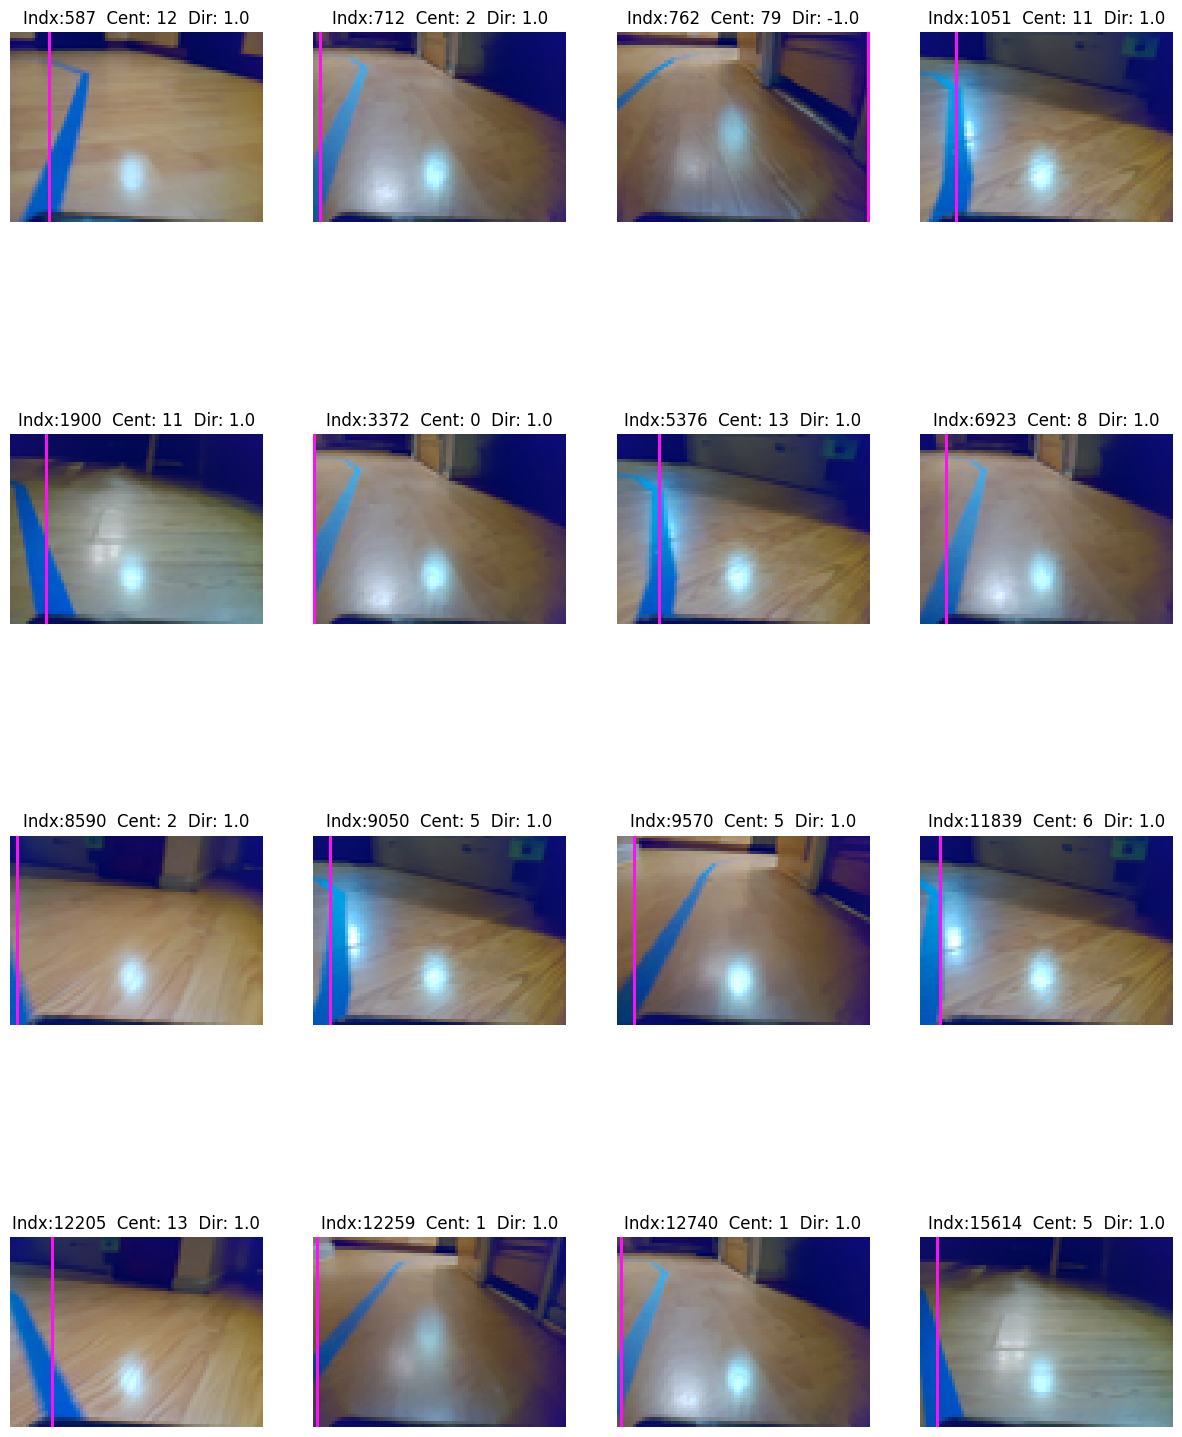

In [60]:
# Plot 16 images that should have been removed to confirm.

plt.figure(figsize=(15, 20))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  image_arr = train_imgs[indices_to_remove][i]
  # Unstandardize image
  image_arr = (image_arr * 255).astype(np.uint8)

  blue_centroid = detect_tape(image_arr)
  # If tape exists in the image
  if blue_centroid is not None:
    image_arr[:, int(blue_centroid), :] = [255, 16, 240]

    title = "Indx:" + str(indices_to_remove[i]) + "  Cent: " + str(int(blue_centroid)) + "  Dir: " + str(train_labels[indices_to_remove][i][-1])
  else:
    title = 'None'

  plt.imshow(image_arr)
  plt.title(title)
  plt.axis("off")

plt.show()

## References

1.   https://docs.opencv.org/3.4/d0/d49/tutorial_moments.html

